In [15]:
#installing Quandl
!pip install quandl

In [20]:
path = path = r'C:\Users\april\Analyzing University Student Retention and Future Success'

In [18]:
# Configure API key 

quandl.ApiConfig.api_key = '_hP-3ytm1d-UiJvWzHXv'

In [23]:
!pip install pandas_datareader

### I kept getting the 403 error  so after trying countless times I looked up any alternative ways to import the data and it gave me this. 

<Axes: title={'center': 'US Unemployment Rate'}, xlabel='DATE'>

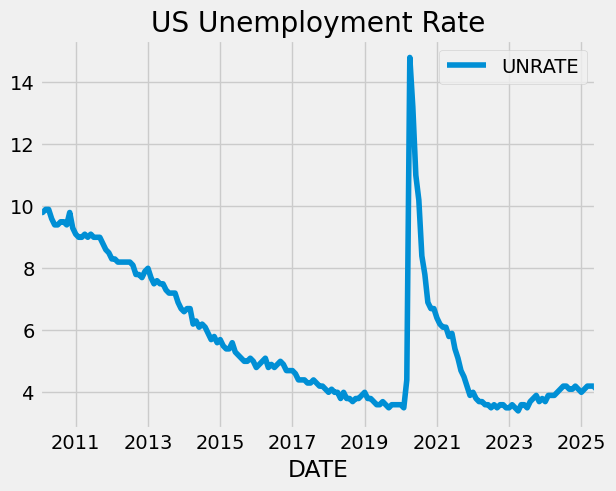

In [24]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2025, 7, 1)

unrate = web.DataReader('UNRATE', 'fred', start, end)
unrate.plot(title="US Unemployment Rate")

In [41]:
# Make a copy of the unrate data and process it
data_sub = unrate.copy()

# If 'unrate' already has the date as the index, you don't need to convert a 'Date' column
data_sub.index.name = 'datetime'  # Rename index (optional)

data_sub

,UNRATE
datetime,
2010-01-01,9.8
2010-02-01,9.8
2010-03-01,9.9
2010-04-01,9.9
2010-05-01,9.6
...,...
2025-02-01,4.1
2025-03-01,4.2
2025-04-01,4.2


In [29]:
unrate.index.name = 'datetime'

# Optionally, if you want to reset the index to have 'Date' as a column:
data_sub = unrate.reset_index()  # This will create a 'DATE' column if that’s the name of the index

print(data_sub.head())

    datetime  UNRATE
0 2010-01-01     9.8
1 2010-02-01     9.8
2 2010-03-01     9.9
3 2010-04-01     9.9
4 2010-05-01     9.6


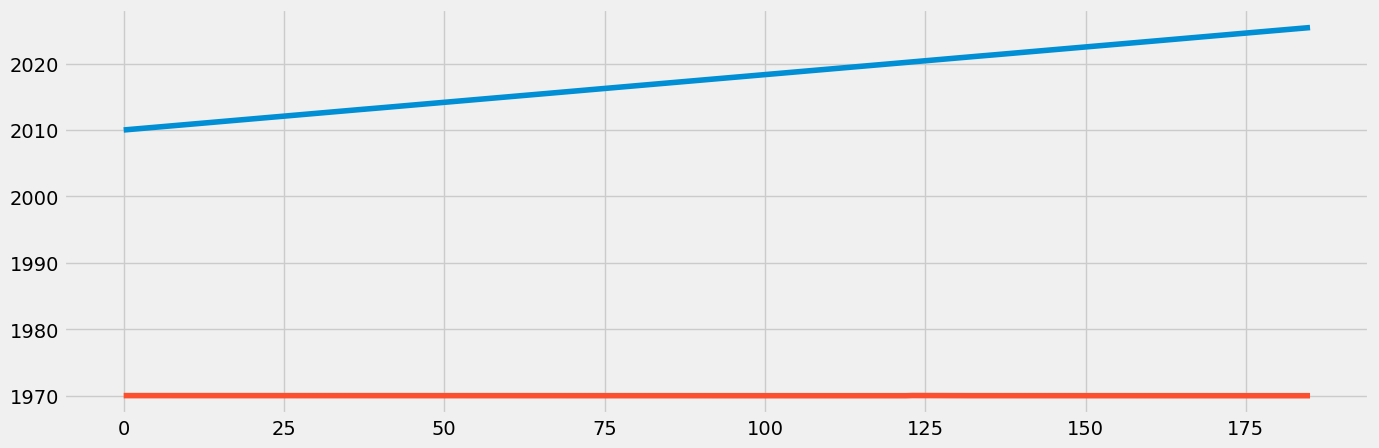

In [30]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [31]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

datetime    0
UNRATE      0
dtype: int64

## Time Series Analysis

In [39]:
print(data_sub)

Empty DataFrame
Columns: [datetime, UNRATE]
Index: []


In [37]:
data_sub = data_sub.asfreq('M') 

In [42]:
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [43]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

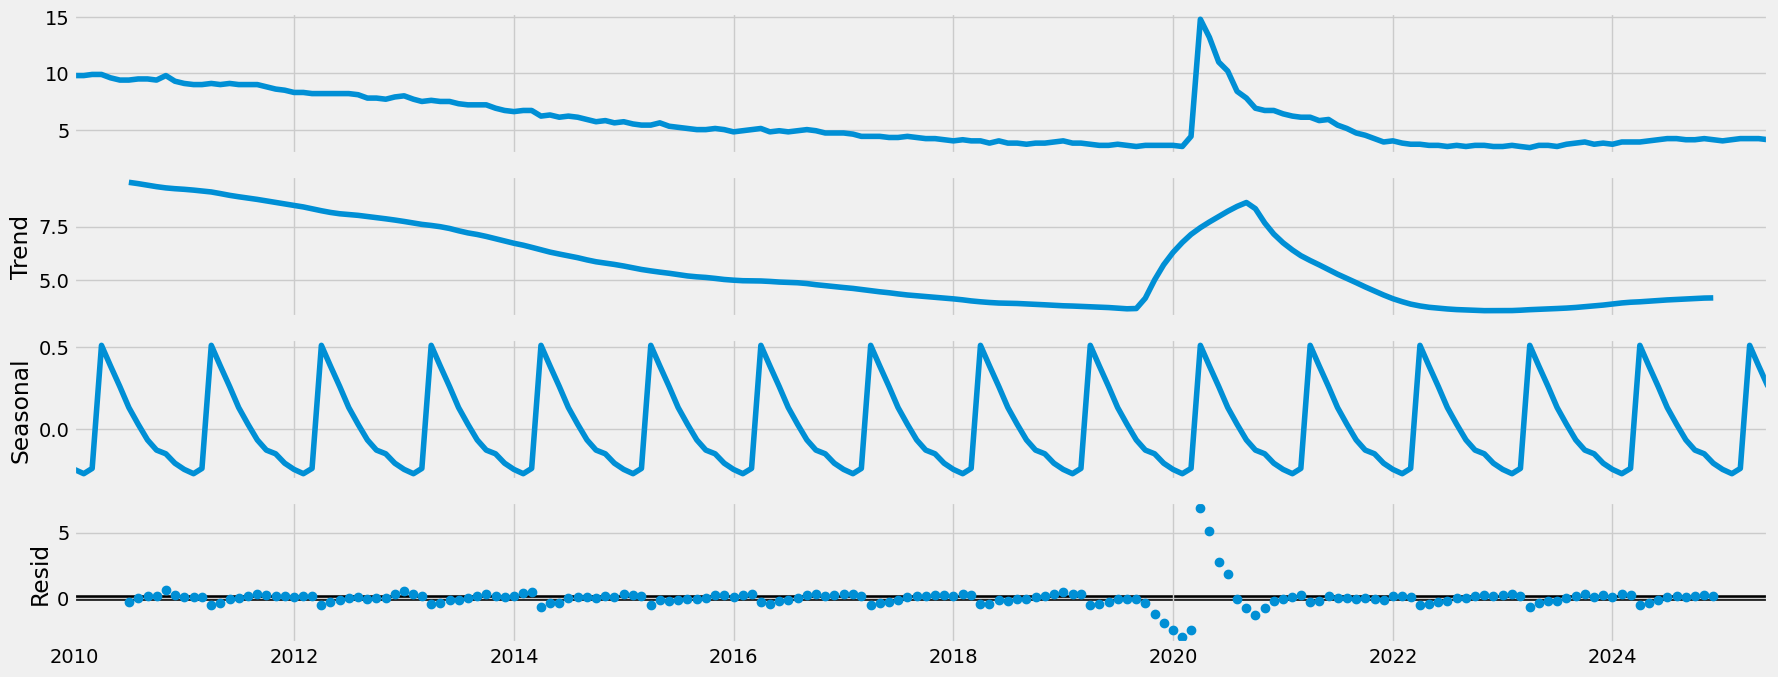

In [44]:
# Plot the separate components

decomposition.plot()
plt.show()

### The unemployment rate gradually went down at first, showing signs of the economy getting better, but then it suddenly jumped up near the end of 2020 and the start of 2021, likely because of the effects of the COVID-19 pandemic. Throughout this time, the seasonal pattern stayed pretty steady, showing regular ups and downs that probably come from things like seasonal jobs and usual industry cycles.

## Testing for Stationality

In [46]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['UNRATE'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.849794
p-value                          0.051505
Number of Lags Used              0.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64


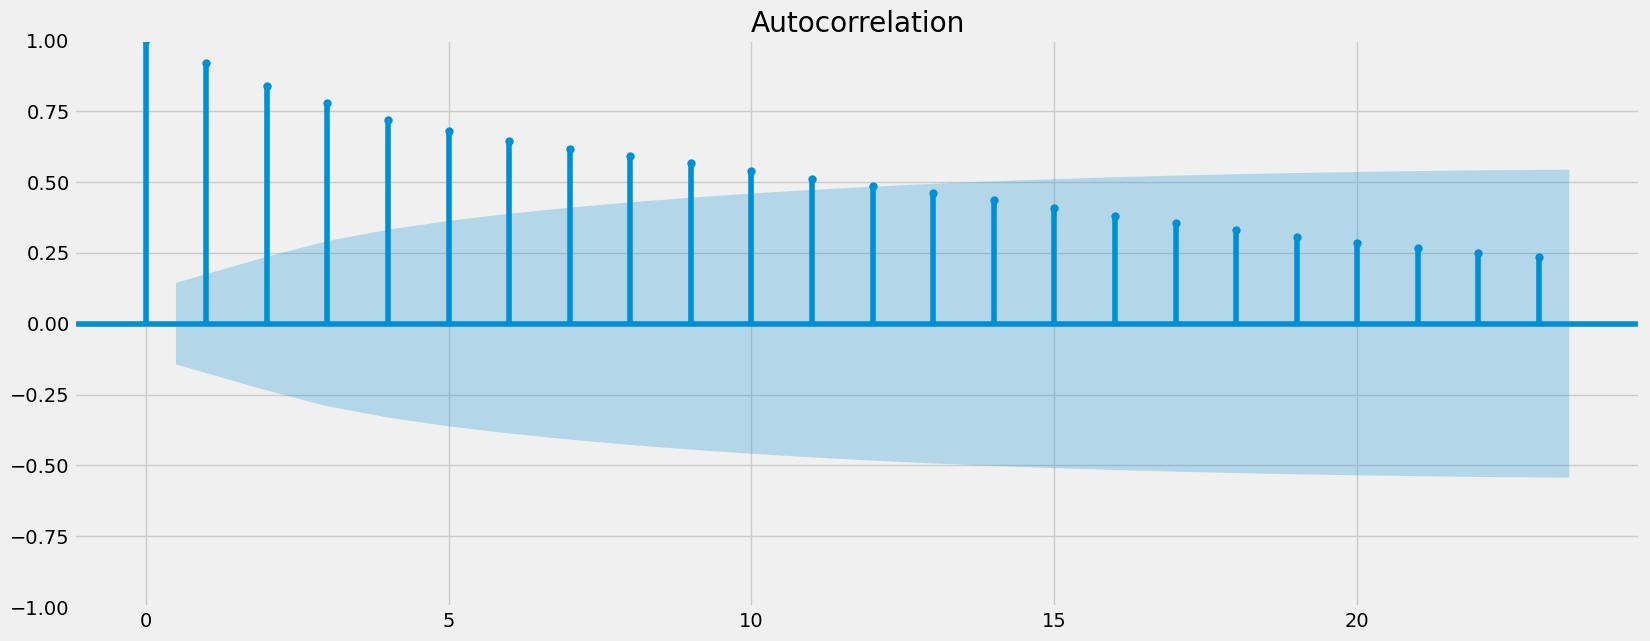

In [47]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### The Dickey-Fuller test statistic is about -2.85, which is just slightly higher than the 5% critical value of -2.88, and the p-value is around 0.05. This means the test is borderline, so we don’t have strong enough evidence to confidently say the time series is stationary at the 5% significance level. However, it’s close, suggesting the series might be nearly stationary or could become stationary after some transformation like differencing.


## Stationary Data

In [48]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [49]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [50]:
data_diff.head()

,UNRATE
datetime,
2010-02-01,0.0
2010-03-01,0.1
2010-04-01,0.0
2010-05-01,-0.3
2010-06-01,-0.2


In [51]:
data_diff.columns

Index(['UNRATE'], dtype='object')

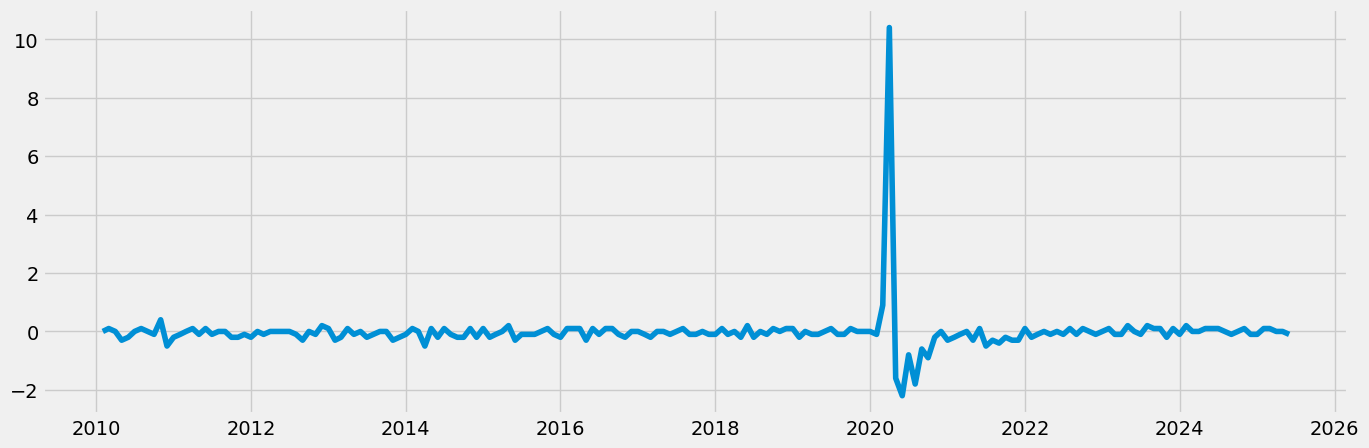

In [52]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [53]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.084757e+01
p-value                        1.558263e-19
Number of Lags Used            1.000000e+00
Number of Observations Used    1.830000e+02
Critical Value (1%)           -3.466598e+00
Critical Value (5%)           -2.877467e+00
Critical Value (10%)          -2.575260e+00
dtype: float64


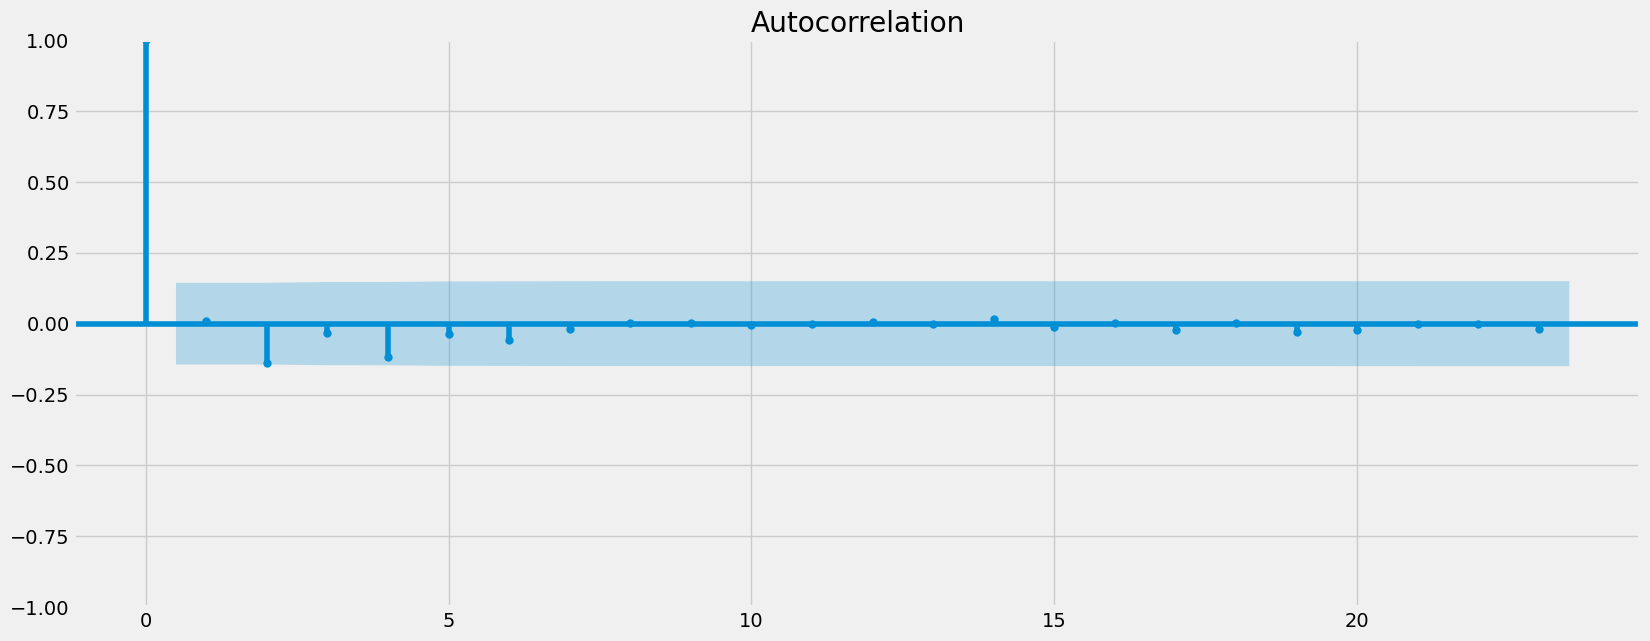

In [54]:
plot_acf(data_diff)
plt.show()

### The Dickey-Fuller test statistic is around -10.85, which is much lower than all the critical values, and the p-value is extremely close to zero. This provides very strong evidence to reject the null hypothesis of a unit root, indicating that the time series is stationary. In other words, after the transformation or differencing applied, the data no longer shows trends or changing variance over time and is stable for time series modeling.


### The autocorrelation plot shows that almost all the lag values fall within the confidence bounds, indicating little to no significant autocorrelation at those lags. The only prominent spike is at lag 0, which is expected since any time series is perfectly correlated with itself at zero lag. This suggests the data doesn’t exhibit strong patterns of correlation over time beyond the immediate value